In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pgmpy.estimators import HillClimbSearch, BicScore, MaximumLikelihoodEstimator
from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import networkx as nx
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import LabelBinarizer


# Loading Dataset

In [2]:
df = pd.read_excel('MaternalHealthRiskData.xlsx', engine='openpyxl')
df.head()


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98,86,high risk
1,35,140,90,13.0,98,70,high risk
2,29,90,70,8.0,100,80,high risk
3,30,140,85,7.0,98,70,high risk
4,35,120,60,6.1,98,76,low risk


# Cleaning of Dataset

In [3]:
def data_preprocessing(data_frame):
    data_cleaned = data_frame[data_frame['HeartRate'] >= 20].copy()

    # Replace missing numerical values
    numerical_features = data_cleaned.select_dtypes(include=['float64', 'int64']).columns
    for column in numerical_features:
        data_cleaned[column].fillna(data_cleaned[column].mean(), inplace=True)

    # standardize 
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    data_cleaned[numerical_features] = scaler.fit_transform(data_cleaned[numerical_features])

    # fill in missing categorical features
    categorical_features = data_cleaned.select_dtypes(include=['object']).columns
    for column in categorical_features:
        data_cleaned[column].fillna(data_cleaned[column].mode()[0], inplace=True)
    
    return data_cleaned

data_cleaned = data_preprocessing(df)



In [4]:
summary_data = data_cleaned.groupby("RiskLevel").mean()

print("Summary Statistics in Relation to overall Dataset:")
print(summary_data.describe())
print("\n")

Summary Statistics in Relation to overall Dataset:
            Age  SystolicBP  DiastolicBP        BS  BodyTemp  HeartRate
count  3.000000    3.000000     3.000000  3.000000  3.000000   3.000000
mean   0.044693    0.065041     0.058488  0.096350  0.025474   0.031498
std    0.371438    0.502980     0.489960  0.813633  0.211083   0.249128
min   -0.220982   -0.401279    -0.283690 -0.458493 -0.216607  -0.178003
25%   -0.167524   -0.201455    -0.222151 -0.370656 -0.047327  -0.106239
50%   -0.114066   -0.001631    -0.160612 -0.282819  0.121953  -0.034475
75%    0.177531    0.298200     0.229577  0.373771  0.146515   0.136249
max    0.469128    0.598032     0.619765  1.030361  0.171078   0.306973




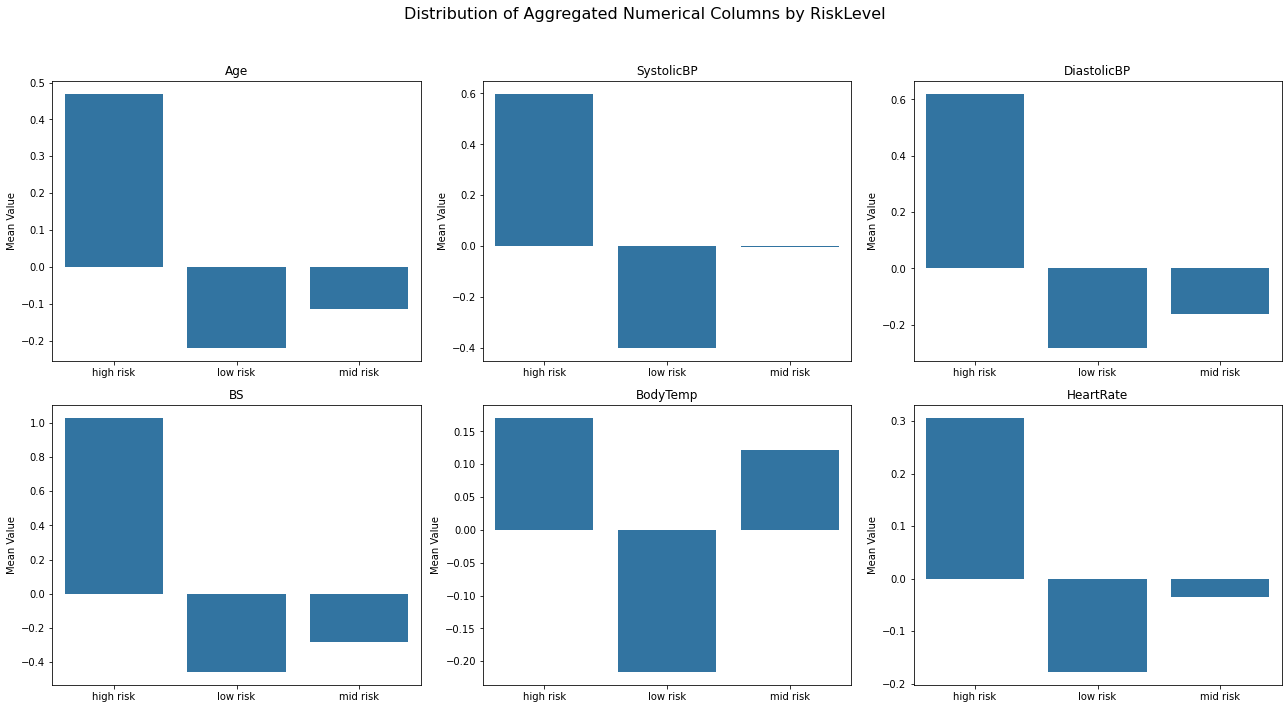

In [5]:
# Set up the figure and axes
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
fig.suptitle('Distribution of Aggregated Numerical Columns by RiskLevel', fontsize=16)

# List of numerical columns
num_columns = ["Age", "SystolicBP", "DiastolicBP", "BS", "BodyTemp", "HeartRate"]

# Plot distribution for each numerical column
for ax, column in zip(axes.flatten(), num_columns):
    sns.barplot(x='RiskLevel', y=column, data=summary_data, ax=ax)
    ax.set_title(column)
    ax.set_ylabel('Mean Value')
    ax.set_xlabel('')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('distribution')
plt.show()

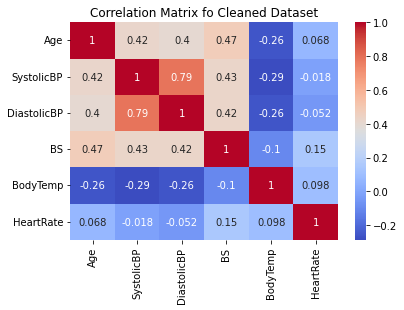

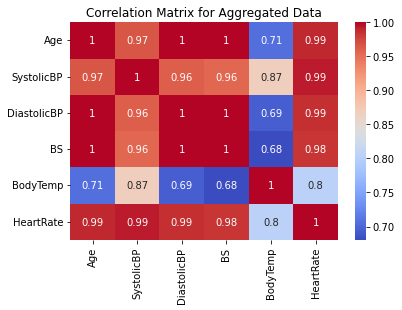

In [6]:
correlation_cleaned = data_cleaned[num_columns].corr()
sns.heatmap(correlation_cleaned, annot=True, cmap="coolwarm")
plt.title('Correlation Matrix fo Cleaned Dataset')
plt.savefig("Correlation Matrix fo Cleaned Dataset")
plt.show()

correlation_summary = summary_data[num_columns].corr()
sns.heatmap(correlation_summary, annot=True, cmap="coolwarm")
plt.title('Correlation Matrix for Aggregated Data')
plt.savefig("Correlation Matrix fo Aggregated Data")
plt.show()


In [7]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

data = data_preprocessing(df)


numerical_features = data.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_features:
    data[col] = pd.cut(data[col].astype(float), bins=3, labels=['low', 'medium', 'high'])  # Overwrite the existing columns


sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, val_index in sss.split(data, data['RiskLevel']):
    training_data = data.iloc[train_index]
    val_data = data.iloc[val_index]

def evaluate_model(max_indegree, training_data, val_data):
    hc = HillClimbSearch(training_data)
    bic = BicScore(training_data)
    best_model_structure = hc.estimate(scoring_method=bic, max_indegree=max_indegree)
    model = BayesianNetwork(best_model_structure.edges())
    model.fit(training_data, estimator=MaximumLikelihoodEstimator)
    bn_nodes = model.nodes()
    infer = VariableElimination(model)
    val_accuracy = get_accuracy(val_data, model, infer)
    return val_accuracy, model, infer, bn_nodes

def get_accuracy(data_set, model, infer):
    accuracy_count = 0
    for _, row in data_set.iterrows():
        true_value = row['RiskLevel']
        evidence_data = {col: row[col] for col in data_set.columns if col != 'RiskLevel' and col in model.nodes()}  # Removed _3bins check

        predicted_distribution = infer.query(variables=['RiskLevel'], evidence=evidence_data)
        categories = ['high risk', 'low risk', 'mid risk']  
        predicted_value = categories[np.argmax(predicted_distribution.values)]
        if predicted_value == true_value:
            accuracy_count += 1
    return (accuracy_count / len(data_set)) * 100


max_indegrees = list(range(1, 6)) 

results = {}
models = {}
infers = {}
bn_nodes_dict = {}

for max_indegree in max_indegrees:
    val_accuracy, model, infer, bn_nodes = evaluate_model(max_indegree, training_data, val_data)
    results[max_indegree] = val_accuracy
    models[max_indegree] = model
    infers[max_indegree] = infer
    bn_nodes_dict[max_indegree] = bn_nodes

best_max_indegree = max(results, key=results.get)
best_model = models[best_max_indegree]
best_infer = infers[best_max_indegree]
best_bn_nodes = bn_nodes_dict[best_max_indegree]
print(f"Best max_indegree: {best_max_indegree} with validation accuracy: {results[best_max_indegree]:.2f}%")


  0%|          | 0/1000000 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be chang

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be chang

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be chang

  0%|          | 0/1000000 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be chang

  0%|          | 0/1000000 [00:00<?, ?it/s]

Best max_indegree: 2 with validation accuracy: 65.52%


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pgmpy/estimators/base.py:170: FutureWarning: The default of observed=False is deprecated and will be chang

In [8]:
def get_predictions(data_set, model, infer):
    predictions = []
    true_values = []
    for _, row in data_set.iterrows():
        true_value = row['RiskLevel']
        true_values.append(true_value)
        evidence_data = {col: row[col] for col in data_set.columns if col.endswith('_3bins') and col in model.nodes()}
        predicted_distribution = infer.query(variables=['RiskLevel'], evidence=evidence_data)
        categories = ['high risk', 'low risk', 'mid risk']  
        predicted_value = categories[np.argmax(predicted_distribution.values)]
        predictions.append(predicted_value)
    return predictions, true_values

test_predictions, test_true_values = get_predictions(val_data, best_model, best_infer)


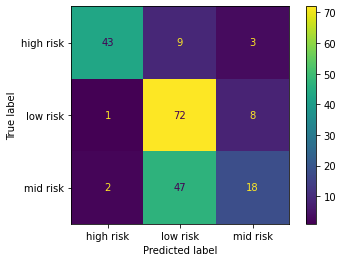

Test Accuracy: 65.52%
----------------------------------------
Metrics for high risk:
Precision: 0.93
Recall: 0.78
F1 Score: 0.85
----------------------------------------
Metrics for low risk:
Precision: 0.56
Recall: 0.89
F1 Score: 0.69
----------------------------------------
Metrics for mid risk:
Precision: 0.62
Recall: 0.27
F1 Score: 0.38
----------------------------------------


In [9]:
predictions = []
true_values = []

for _, row in val_data.iterrows():
    true_value = row['RiskLevel']
    evidence_data = {col: row[col] for col in val_data.columns if col != 'RiskLevel' and col in best_model.nodes()}
    predicted_distribution = best_infer.query(variables=['RiskLevel'], evidence=evidence_data)
    categories = ['high risk', 'low risk', 'mid risk']  
    predicted_value = categories[np.argmax(predicted_distribution.values)]
    predictions.append(predicted_value)
    true_values.append(true_value)

cm = confusion_matrix(true_values, predictions, labels=categories)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories).plot()
plt.savefig('confusion_matrix')
plt.show()

test_accuracy = accuracy_score(true_values, predictions)

categories = ['high risk', 'low risk', 'mid risk']  
metrics = {}
for risk_level in categories:
    metrics[risk_level] = {
        "Precision": precision_score(true_values, predictions, labels=categories, average=None, zero_division=0)[categories.index(risk_level)],
        "Recall": recall_score(true_values, predictions, labels=categories, average=None, zero_division=0)[categories.index(risk_level)],
        "F1 Score": f1_score(true_values, predictions, labels=categories, average=None, zero_division=0)[categories.index(risk_level)]
    }

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print("----------------------------------------")
for risk_level in categories:
    print(f"Metrics for {risk_level}:")
    print(f"Precision: {metrics[risk_level]['Precision']:.2f}")
    print(f"Recall: {metrics[risk_level]['Recall']:.2f}")
    print(f"F1 Score: {metrics[risk_level]['F1 Score']:.2f}")
    print("----------------------------------------")


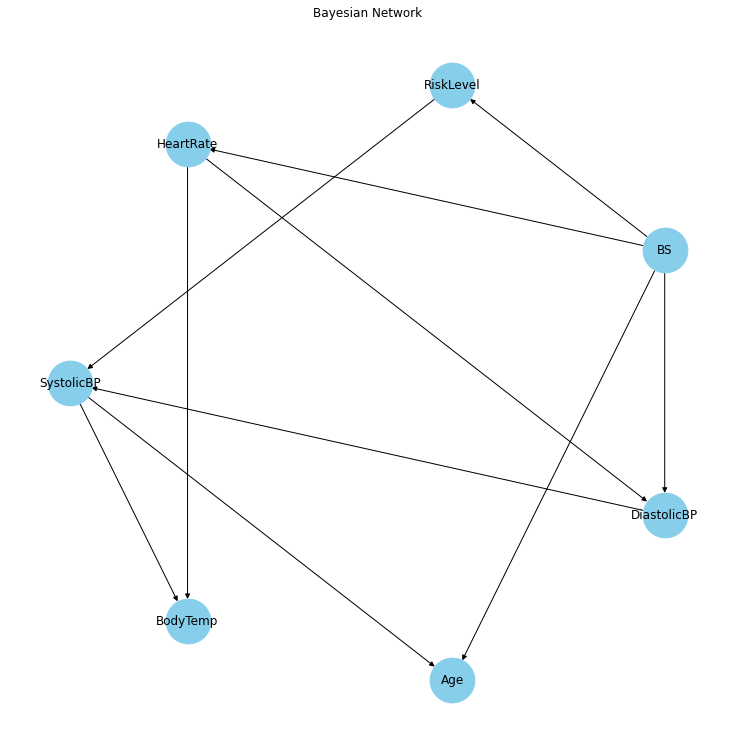

In [10]:
def draw_BN_simple(model):
    plt.figure(figsize=(10, 10))
    pos = nx.shell_layout(model)
    nx.draw(model, pos, with_labels=True, node_size=2000, node_color="skyblue")
    plt.title("Bayesian Network")
    plt.savefig("BN")
    plt.show()

draw_BN_simple(best_model)

In [15]:
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.preprocessing import label_binarize

y_true_onehot = label_binarize(true_values, classes=categories)

y_pred_probabilities = []
for _, row in val_data.iterrows():
    evidence_data = {col: row[col] for col in val_data.columns if col != 'RiskLevel' and col in best_model.nodes()}
    predicted_distribution = best_infer.query(variables=['RiskLevel'], evidence=evidence_data)
    y_pred_probabilities.append(predicted_distribution.values)

auc_scores = {}
for i, category in enumerate(categories):
    if len(np.unique(y_true_onehot[:, i])) == 1:  
        auc = float('nan')
    else:
        auc = roc_auc_score(y_true_onehot[:, i], [yp[i] for yp in y_pred_probabilities])
    auc_scores[category] = auc

mean_auc = np.nanmean(list(auc_scores.values()))

logloss_scores = {}
for i, category in enumerate(categories):
    logloss_scores[category] = log_loss(y_true_onehot[:, i], [yp[i] for yp in y_pred_probabilities], labels=[0, 1])
overall_logloss = log_loss(y_true_onehot, y_pred_probabilities)

print("Metrics for each category:")
print("----------------------------------------")
for category in categories:
    print(f"{category}:")
    print(f"AUC-ROC: {auc_scores[category]:.2f}")
    print(f"Log Loss: {logloss_scores[category]:.2f}")
    print("----------------------------------------")
print(f"Overall AUC-ROC: {mean_auc:.2f}")
print(f"Overall Log Loss: {overall_logloss:.2f}")


Metrics for each category:
----------------------------------------
high risk:
AUC-ROC: 0.94
Log Loss: 0.25
----------------------------------------
low risk:
AUC-ROC: 0.73
Log Loss: 0.51
----------------------------------------
mid risk:
AUC-ROC: 0.69
Log Loss: 0.56
----------------------------------------
Overall AUC-ROC: 0.79
Overall Log Loss: 0.72
